In [1]:
import numpy as np
import xarray as xr
from main import paths, lx
import matplotlib.pyplot as plt
from main_valid import EUC_depths, plot_eq_velocity
from main_valid import open_tao_data, plot_tao_timeseries

# Path to save figures, save data and OFAM model output.
fpath, dpath, xpath, lpath, tpath = paths()


def plot_tao_velocity_timeseries():
    """Plot TAO/TRITION equatorial velocity with interpolation."""
    for interp, new_end_v in zip(['', 'linear', 'linear', 'nearest'],
                                 [None, None, -0.1, None]):
        plot_tao_timeseries(ds, interp, T=T, new_end_v=new_end_v)


In [3]:
# Saved data frequency (1 for monthly and 0 for daily data).
T = 1

# Open dataset of TAO data at the frequency.
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))
d3 = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))

DEBUG: Opening TAO mon data. Depth=slice(10, 360, None). SI=True


In [260]:
du = ds[0].u_1205
du = du.where(du >= 0)
depths=ds[0].depth
u = np.ma.masked_invalid(du)

# Maximum and minimum velocity at each time step.
v_max = du.max(axis=1, skipna=True)
v_max_half = v_max/2

# Index of maximum and minimum velocity at each time.
v_imax = np.nanargmax(u, axis=1)

z1i = (v_imax.copy()*np.nan)
z2i = (v_imax.copy()*np.nan)
z1 = v_imax.copy()*np.nan
z2 = v_imax.copy()*np.nan
empty = 0
skip_t = 0
skip_l = 0
count = 0
target = v_bnd

for t in range(u.shape[0]):
    
    # Make sure entire slice isn't all empty
    if not (u[t] == True).mask.all() and not np.ma.is_masked(v_imax[t]):
        
        # Set target velocity as half the maximum at each timestep.
        if v_bnd == 'half_max':
            target = v_max_half[t] + v_max_half[t]/100
            
        # Subset velocity on either side of the maximum velocity.
        top = du[t, slice(0, v_imax[t])]
        low = du[t, slice(v_imax[t], len(depths))]
        
        # Mask velocities that are greater than the maxmimum.
        top = top.where(top <= target) 
        low = low.where(low <= target)
        
        # Find the closest velocity depth/index if both the 
        # top and lower arrays are not all NaN.
        if all([not all(np.isnan(top)), not all(np.isnan(low))]):
            z1i[t] = idx_1d(top, target)
            z1[t] = depths[int(z1i[t])]
            z2i[t] = idx_1d(low, target) + v_imax[t]
            z2[t] = depths[int(z2i[t])]
            count += 1
        
        # Check if skipped steps due to missing top depth (and vice versa).
        if all(np.isnan(low)) and not all(np.isnan(top)):
            skip_t += 1
        elif all(np.isnan(top)) and not all(np.isnan(low)):
            skip_l += 1
    else:
        empty+=1
            
print(('count={} tot={}, empty={} skip={} skip_t={} skip_l={}.'
                .format(count, u.shape[0], empty, skip_t, skip_l)))

count=112 tot=203, empty=5 skip=171 skip_t=63 skip_l=23.


In [251]:
count=113 tot=203, empty=5 skip=85 skip_t=62 skip_l=23.

# from main import idx_1d
# print(target.item())
# top = top
# # min(range(len(top)), key=lambda i: abs(top[i] - target))
# q = idx_1d(top, target)
# print(q, du[t, q].item())
all(np.isnan(top))
print(u.shape[0], u.shape[0] - count, count, extra)
f = [False, False]
f2 = [False, True]

all(np.isnan(low)) == False
all([all(np.isnan(top)), all(np.isnan(low))])
print(extra_l, extra_t)
not all(np.isnan(top))

203 203 0 0
23 63


True

(400.0, 0.0)

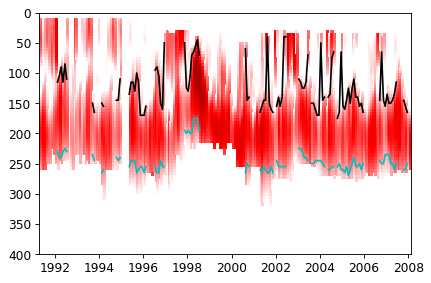

In [186]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

im = ax.pcolormesh(du.time, depths, du.transpose('depth', 'time'),  
                   cmap=plt.cm.seismic, vmax=1.20, vmin=-1.20)
ax.plot(np.ma.masked_where(np.isnan(z1), du.time),
        np.ma.masked_where(np.isnan(z1), z1), 'k')
ax.plot(np.ma.masked_where(np.isnan(z2), du.time),
        np.ma.masked_where(np.isnan(z2), z2), 'c')
ax.set_ylim(400, 0)

In [175]:
z1 >= z2

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater_equal
  """Entry point for launching an IPython kernel.


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [157]:
np.argmin(z2)
z2iz1[22][22]

-9223372036854775808

In [92]:
z1i[t]

-9223372036854775808

In [262]:
def EUC_vbounds(du, depths, i, v_bnd=0.3, index=False):
    """Find EUC max velocity/position and lower EUC depth boundary.

    Args:
        du (array): Velocity values.
        depths (array): Depth values.
        i ({0, 1, 2}): Index of longitude.
        v_bnd (float, str): Minimum velocity to include. Defaults to 0.3.
        index (bool, optional): Return depth index or value. Defaults to False.

    Returns:
        v_max (array): Maximum velocity at each timestep.
        array: Depth of maximum velocity at each timestep.
        array: Deepest EUC depth based on v_bnd at each timestep.

    """
    du = du.where(du >= 0)
    u = np.ma.masked_invalid(du)

    # Maximum and minimum velocity at each time step.
    v_max = du.max(axis=1, skipna=True)
    v_max_half = v_max/2

    # Index of maximum and minimum velocity at each time.
    v_imax = np.nanargmax(u, axis=1)

    z1i = (v_imax.copy()*np.nan)
    z2i = (v_imax.copy()*np.nan)
    z1 = v_imax.copy()*np.nan
    z2 = v_imax.copy()*np.nan

    count, empty, skip_t, skip_l = 0, 0, 0, 0

    for t in range(u.shape[0]):
        # Make sure entire slice isn't all empty
        if not (u[t] == True).mask.all() and not np.ma.is_masked(v_imax[t]):

            # Set target velocity as half the maximum at each timestep.
            if v_bnd == 'half_max':
                target = v_max_half[t] + v_max_half[t]/100

            # Subset velocity on either side of the maximum velocity.
            top = du[t, slice(0, v_imax[t])]
            low = du[t, slice(v_imax[t], len(depths))]

            # Mask velocities that are greater than the maxmimum.
            top = top.where(top <= target)
            low = low.where(low <= target)

            # Find the closest velocity depth/index if both the
            # top and lower arrays are not all NaN.
            if all([not all(np.isnan(top)), not all(np.isnan(low))]):
                z1i[t] = idx_1d(top, target)
                z1[t] = depths[int(z1i[t])]
                z2i[t] = idx_1d(low, target) + v_imax[t]
                z2[t] = depths[int(z2i[t])]
                count += 1

            # Check if skipped steps due to missing top depth (and vice versa).
            if all(np.isnan(low)) and not all(np.isnan(top)):
                skip_t += 1
            elif all(np.isnan(top)) and not all(np.isnan(low)):
                skip_l += 1
        else:
            empty += 1

    data_name = 'OFAM3' if hasattr(du, 'st_ocean') else 'TAO/TRITION'

    print('{} {}: v_bnd={} tot={} count={} null={} skip_T={}, skip_L={}'
                .format(data_name, lx['lons'][i], v_bnd, u.shape[0], count,
                        empty, skip_t, skip_l))
    if not index:
        return v_max, z1, z2
    else:
        return v_max, z1i, z2i

DEBUG: Opening TAO mon data. Depth=slice(10, 360, None). SI=True


TAO/TRITION 165: v_bnd=half_max tot=202 count=113 null=5 skip_T=61, skip_L=23
OFAM3 165: v_bnd=half_max tot=202 count=172 null=0 skip_T=4, skip_L=26
TAO/TRITION 190: v_bnd=half_max tot=296 count=240 null=35 skip_T=11, skip_L=10


/g/data1a/e14/as3189/OFAM/scripts/main_valid.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([0.925, 0.11, 0.019, 0.355])


OFAM3 190: v_bnd=half_max tot=295 count=282 null=0 skip_T=1, skip_L=12
TAO/TRITION 220: v_bnd=half_max tot=272 count=231 null=25 skip_T=0, skip_L=16


/g/data1a/e14/as3189/OFAM/scripts/main_valid.py:104: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar_ax = fig.add_axes([0.925, 0.11, 0.019, 0.355])


OFAM3 220: v_bnd=half_max tot=271 count=268 null=0 skip_T=1, skip_L=2


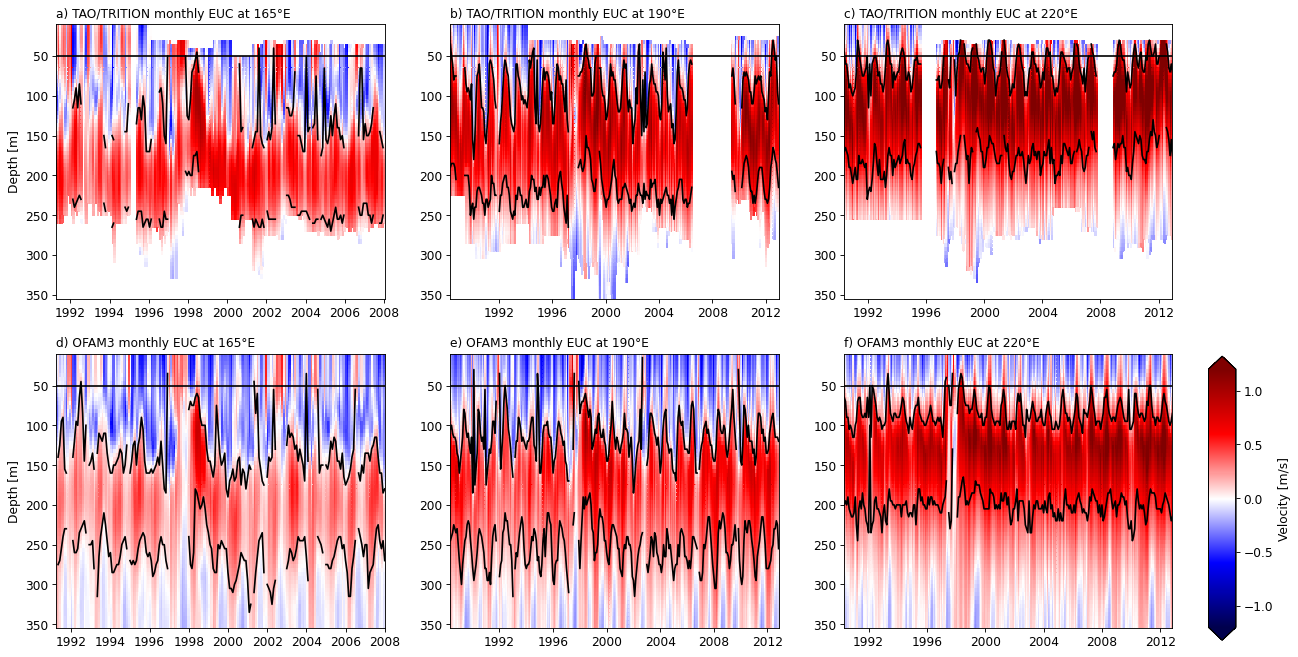

In [266]:
# Open dataset of TAO data at the frequency.
ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(10, 360))
d3 = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))

def plot_tao_velocity_timeseries():
    """Plot TAO/TRITION equatorial velocity with interpolation."""
    for interp, new_end_v in zip(['', 'linear', 'linear', 'nearest'],
                                 [None, None, -0.1, None]):
        plot_tao_timeseries(ds, interp, T=T, new_end_v=new_end_v)


def plot_eq_velocity_timeseries_tao_ofam(ds, d3, v_bnd=0.3,
                                         hline=50, add_bounds=True):
    """Plot TAO/TRITION and OFAM3 equatorial velocity timeseries.

    Args:
        ds (list): List of TAO/TRITION datasets at three longitudes.
        d3 (array): OFAM3 climotology velocity dataset.
        v_bnd (float): EUC_depths velocity boundary. Defaults to 0.3.
        hline (int, optional): Depth level line to plot. Defaults to 50.
        add_bounds (bool, optional): Add AUC_depth boundary. Defaults to True.

    Returns:
        None.

    """
    time_bnds_ofam = [[10*12+3, 27*12+1], [7*12+4, -1], [9*12+4, -1]]
    time_bnds_tao = [[0, -1], [0, 24*12+8], [0, 22*12+8]]

    fig = plt.figure(figsize=(18, 10))

    for i, du in enumerate(ds):
        # TAO/TRITION row.
        du = du.isel(time=slice(time_bnds_tao[i][0], time_bnds_tao[i][1]))
        name = '{}TAO/TRITION {} EUC at {}°E'.format(lx['l'][i],
                                                     lx['frq_long'][T],
                                                     lx['lons'][i])
        u = du.u_1205.transpose('depth', 'time')
        ax = plot_eq_velocity(fig, du.depth, du.time, u, i+1, name, rows=2)

        # Plot EUC bottom depths.
        if add_bounds:
            v_max, depth_max, depth_end = EUC_vbounds(du.u_1205, du.depth, i, v_bnd='half_max')
            ax.plot(np.ma.masked_where(np.isnan(depth_end), du.time),
                    np.ma.masked_where(np.isnan(depth_end), depth_end), 'k')
            ax.plot(np.ma.masked_where(np.isnan(depth_end), du.time),
                    np.ma.masked_where(np.isnan(depth_end), depth_max), 'k')
            ax.axhline(hline, color='k')

        # OFAM3 row.
        dq = d3.sel(xu_ocean=lx['lons'][i])
        dq = dq.isel(Time=slice(time_bnds_ofam[i][0], time_bnds_ofam[i][1]))
        name = '{}OFAM3 {} EUC at {}°E '.format(lx['l'][i+3],
                                                lx['frq_long'][T],
                                                lx['lons'][i])
        u = dq.u.transpose('st_ocean', 'Time')
        ax = plot_eq_velocity(fig, dq.st_ocean, dq.Time, u, i+4, name, rows=2)

        # Plot EUC bottom depths.
        if add_bounds:
            v_max, depth_max, depth_end = EUC_vbounds(dq.u, dq.st_ocean, i, v_bnd='half_max')
            ax.plot(dq.Time, depth_end, 'k')
            ax.plot(dq.Time, depth_max, 'k')
            ax.axhline(50, color='k')

        if add_bounds:
            save_name = 'tao_ofam_depth_{}_bnds_{}.png'.format(lx['frq'][T],
                                                               v_bnd)
        else:
            save_name = 'tao_ofam_depth_{}_{}.png'.format(lx['frq'][T], v_bnd)
    plt.show()
#     plt.savefig(fpath.joinpath('tao', save_name))

    return
plot_eq_velocity_timeseries_tao_ofam(ds, d3, v_bnd=0.3,
                                         hline=50, add_bounds=True)

OFAM3 165: v_bnd=half_max tot=384 count=338 null=0 skip_T=6, skip_L=40
OFAM3 190: v_bnd=half_max tot=384 count=362 null=0 skip_T=5, skip_L=17
OFAM3 220: v_bnd=half_max tot=384 count=379 null=0 skip_T=1, skip_L=4


DEBUG: Opening TAO mon data. Depth=slice(25, 350, None). SI=True


TAO/TRITION 165: v_bnd=half_max tot=203 count=113 null=5 skip_T=62, skip_L=23
TAO/TRITION 190: v_bnd=half_max tot=340 count=280 null=36 skip_T=13, skip_L=11
TAO/TRITION 220: v_bnd=half_max tot=311 count=260 null=31 skip_T=0, skip_L=20


DEBUG: R=0.94, p=0.000 (stats.spearmanr)
DEBUG: Slope=0.34 Intercept=1.40 R=0.90 P=0.000 stder=0.01
DEBUG: R=0.91, p=0.000 (stats.spearmanr)
DEBUG: Slope=0.36 Intercept=-4.49 R=0.90 P=0.000 stder=0.01
DEBUG: R=0.86, p=0.000 (stats.spearmanr)
DEBUG: Slope=0.31 Intercept=-8.82 R=0.87 P=0.000 stder=0.01


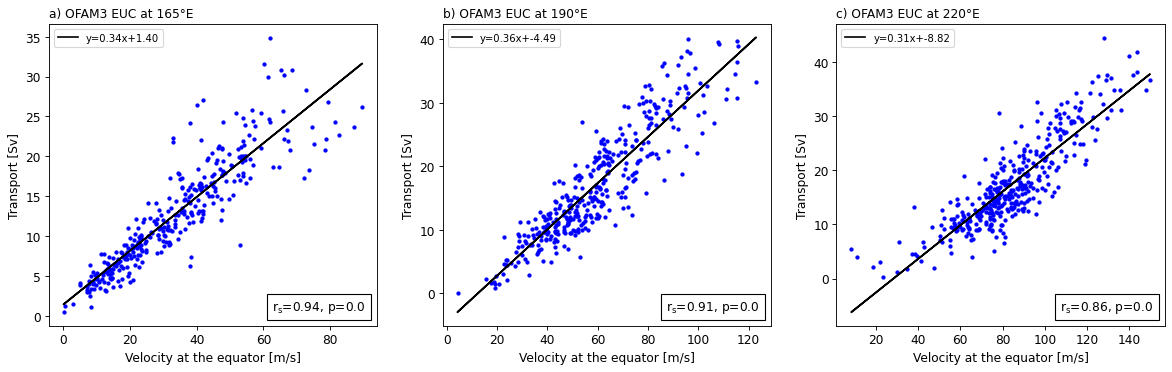

In [280]:

def eq_velocity_transport_reg(z1=25, z2=350, T=1, dk=5, v_bnd='half_max'):
    """Return OFAM3 and TAO equatorial velocity sum and transport.

    Args:
        z1 (int, optional): Lowest depth to slice. Defaults to 25.
        z2 (int, optional): Largest depth to slice. Defaults to 350.
        T ({0, 1}, optional): Saved data frequency (day/month). Defaults to 1.
        dk (int, optional): Distance between depth layers. Defaults to 5.
        method (str, optional): Method to calculate depths.
            Defaults to 'EUC_depths'.

    Returns:
        d3 (array): OFAM3 climatological velocity.
        d3v (array): OFAM3 depth integrated velocity at equator.
        d3t (array): OFAM3 transport at equator.
        ds (list): TAO velocity at three longitudes.
        dsv (list): TAO velocity sum at three longitudes.

    TODO: Add other method options.

    """
    # OFAM3.
    d3 = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
    d3 = d3.sel(st_ocean=slice(z1, z2))

    # Add transport between depths.
    d3t = d3.uvo.isel(st_ocean=0).copy()*np.nan

    # Add velocity between depths.
    d3v = d3.u.isel(st_ocean=0).copy()*np.nan

    for i in range(3):
        dq = d3.sel(xu_ocean=lx['lons'][i])
        v_max, d1, d2 = EUC_vbounds(dq.u, dq.st_ocean, i, v_bnd=v_bnd)
        for t in range(len(dt.Time)):
            if not np.isnan(d1[t]):
                # Transport
                tmp1 = d3.uvo.isel(xu_ocean=i, Time=t)
                d3t[t, i] = tmp1.where(tmp1 > 0).sel(
                    st_ocean=slice(d1[t], d2[t])).sum(
                        dim='st_ocean').item()

                # Velocity
                tmp2 = d3.u.isel(xu_ocean=i, Time=t)
                d3v[t, i] = (tmp2*dk).where(tmp2 > 0).sel(
                    st_ocean=slice(d1[t], d2[t])).sum(
                        dim='st_ocean').item()

    # TAO/TRITION.
    ds = open_tao_data(frq=lx['frq_short'][T], dz=slice(z1, z2))

    # Calculate TAO/TRITION EUC transport based on OFAM3 regression.
    dsv = [ds[i].u_1205.isel(depth=0)*np.nan for i in range(3)]

    for i in range(3):
        v_max, d1, d2 = EUC_vbounds(ds[i].u_1205, ds[i].depth, i, v_bnd='half_max')
        for t in range(len(ds[i].u_1205.time)):
            if not np.isnan(d2[t]):
                tmp = ds[i].u_1205.isel(time=t).sel(
                    depth=slice(d1[t], d2[t]))
                dsv[i][t] = (tmp*dk).where(tmp > 0).sum(dim='depth').item()

    return d3, d3v, d3t, ds, dsv


def plot_ofam_transport_correlation(z1=25, z2=350, T=1, dk=5,
                                    v_bnd='half_max'):
    """Plot OFAM3  equatorial velocity and transport correlation."""
    d3, d3v, d3t, ds, dsv = eq_velocity_transport_reg(z1, z2, T, dk, v_bnd)
    fig = plt.figure(figsize=(18, 5))

    for i, lon in enumerate(lx['lons']):
        cor_scatter_plot(fig, i+1, d3v.isel(xu_ocean=i),
                         d3t.isel(xu_ocean=i)/SV,
                         name='{}OFAM3 EUC at {}°E v_bnd={}'.format(lx['l'][i], lon, v_bnd),
                         ylabel="Transport [Sv]",
                         xlabel="Velocity at the equator [m/s]",
                         cor_loc=4)

    save_name = 'ofam3_eq_transport_velocity_cor_vbnd_{}.png'.format(v_bnd)
    plt.savefig(fpath.joinpath('tao', save_name))
    plt.show()
    return
from main_valid import open_tao_data, cor_scatter_plot
from main import SV
dt = xr.open_dataset(dpath.joinpath('ofam_ocean_u_EUC_int_transport.nc'))
plot_ofam_transport_correlation(z1=25, z2=350, T=1, dk=5,
                                    v_bnd='half_max')

In [275]:
x = xr.open_dataset((dpath/('ofam_EUC_transport_{}_{}.nc'
                     .format('static', lx['exp_abr'][0]))))
x

<xarray.Dataset>
Dimensions:   (Time: 11688, xu_ocean: 3)
Coordinates:
  * Time      (Time) datetime64[ns] 1981-01-01T12:00:00 ... 2012-12-31T12:00:00
  * xu_ocean  (xu_ocean) int64 165 190 220
Data variables:
    uvo       (Time, xu_ocean) float64 ...

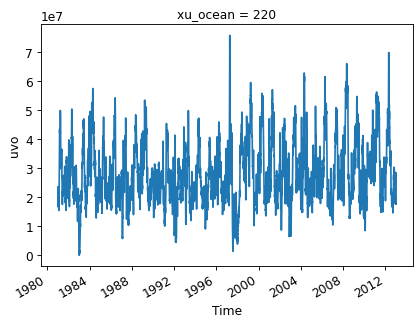